# Describe Dataset

The datataset used for this test is extractracted from a publically-accessible data store, known as the BRFSS -- [Behavior Risk Factor Surveillance System](http://www.cdc.gov/brfss). The BRFSS is an ongoing telephone-based population health survey, conducted by the United States Centers for Disease Control and Pre-vention (CDC). The results of the risk factor survey, including state-based population estimates of diseases and risk factors, are published online annually by the CDC since 1984.

For the test scope, we download the survey concerning the year 2015 (click [here](https://www.cdc.gov/brfss/annual_data/2015/files/LLCP2015XPT.zip) to download the dataset). It is composed by 441456 rows and 330 features. Features can be classified in 2 main categories: *i)* Features directly extracted during the interview process (e.g. AGE); *ii)* Calculated features, which could be intermediate variables (i.e. variables derived from a question response and used to calculate some other variable or risk factor) or variables used to classify respondents (most of them are identified by an underscore, e.g. _BMI4). Detailed infomation about calculated features can be found [here](https://www.cdc.gov/brfss/annual_data/2015/pdf/2015-calculated-variables-version4.pdf). 
Moreover, the questionnaire is comprised by core questions (i.e. questionnaire portion which must be asked by all states), optional modules (i.e. questions on various topics that each state may select
and include in its questionnaire; this type of questions are asked to all eligible respondents.), and state-added questions (i.e. questions that could be added only by some state). For this reason the input dataset is very sparse. 

In [1]:
#used libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
df = pd.read_sas('dataset.xpt')

In [3]:
print("Dataset dimension (NumRows, NumFeatures): ", df.shape)

Dataset dimension (NumRows, NumFeatures):  (441456, 330)


Before to describe the prediction goal, we would like to explore the dataset, doing a simple statistical analyses on all available features. We consider all features as categorical. The ratio of this choice is due to large number of variables involved and by the fact that most questions (e.g variable *HHADULT*: "How many members of your household, including yourself, are 18 years of age or older?") contain some extra value which describe that the user could refuse to response (e.g. value 99) or does not know the response (e.g value 77). Therefore, for the test task we convert all variables as categorical rather than select a few of them and spend time to filter useless information with respect to the prediction task.  

In [4]:
df_cat = pd.DataFrame()
for i in df:
    df_cat[i] = df[i].astype('category')

In the following we show some simple statistic about each variable:
* Count: Describes the number of not null values;
* Unique: Describes the number of unique values;
* top: Describes the mode (in the case of multiple mode only one is shown)
* freq: Describe the frequency of the returned *top* value

In [5]:
df_cat.describe()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
count,441456.0,441456.0,441456,441456,441456,441456,441456.0,4.414560e+05,4.414560e+05,254645.0,...,441456.0,441456.0,438657.0,438657.0,438657.0,441456.0,441456.0,157954.0,157954.0,398069.0
unique,53.0,12.0,415,12,31,2,2.0,2.323600e+04,2.323600e+04,1.0,...,5.0,3.0,4.0,4.0,5.0,3.0,3.0,3.0,3.0,3.0
top,20.0,1.0,b'06022015',b'03',b'09',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,1.0,1.0,2.0
freq,23236.0,44300.0,2148,42406,18669,430541,375059.0,5.300000e+01,5.300000e+01,254645.0,...,150188.0,309251.0,290621.0,290621.0,290621.0,376993.0,349444.0,86683.0,98752.0,269733.0


# Prediction Task
As said before, the input dataset contains questions about a wide range of socio-demographic and health information ( e.g., age, gender, race, household income, employment status, marital status, education, depression, hiv, etc.). We choose the **Diabetes Prediction Task** and we set the variable *DIABETE3* as the dependent variable. In particular, we filter from the original dataset all the interviews (i.e. dataset rows) that have been completed and are related to people having or not diabete (i.e. we remove interviews related to people which had diabete during pregnancy or pre-diabete), and we manually select a subset of the features as independent variables.

Therefore goal of this task is to learn a classifier which is able to discriminate people with diabete from 
healthy people, and learn what are the most related factors to the target variable.

## Explore the Dataset
We consider only a subset of features, that is those we consider most significative or which do not require further cleaning operations (e.g. discretization of continuous variables such as NUMADULT).
The list *selected_features* contains the subset of features that will be used and the set of values to clean (e.g. [7,9, " "]). In particular, for the selected feature the value 7,9 and " "(blank) codify respectively the responses "Don't know", "Refused", "Missing".

Therefore from the input dataset we extract a dataset composed by 441456 rows and 77 columns.

In [6]:
selected_features = [
    ("_STATE",[]),
    ("GENHLTH",[7,9," "]),
    ("HLTHPLN1",[7,9]),
    ("CHECKUP1",[7,8,9," "]),
    ("BPHIGH4",[7,9," "]),
    ("BPMEDS",[7,9," "]),
    ("TOLDHI2",[7,9," "]),
    ("CVDINFR4",[7,9]),
    ("CVDCRHD4",[7,9," "]),
    ("CVDSTRK3",[7,9]),
    ("ASTHMA3", [7,9]),
    ("CHCSCNCR",[7,9," "]),
    ("CHCOCNCR",[7,9]),
    ("CHCCOPD1",[7,9]),
    ("HAVARTH3",[7,9, " "]),
    ("ADDEPEV2",[7,9]),
    ("CHCKIDNY",[7,9]),
    ("SEX",[]),
    ("MARITAL",[9]),
    ("RENTHOM1",[7,9]),
    ("VETERAN3",[7,9," "]),
    ("EMPLOY1",[9]),
    ("INCOME2",[77,99," "]),
    ("QLACTLM2",[7,9, " "]),
    ("USEEQUIP",[7,9," "]),
    ("BLIND",[7,9, " "]),
    ("DECIDE",[7,9," "]),    
    ("DIFFWALK",[7,9," "]),
    ("DIFFDRES",[7,9, " "]),
    ("DIFFALON",[7,9, " "]),
    ("SMOKE100",[7,9, " "]),
    ("EXERANY2",[7,9," "]),
    ("LMTJOIN3",[7,9,10]),
    ("ARTHDIS2",[7,9," "]),
    ("FLUSHOT6",[7,9," "]),    
    ("PNEUVAC3",[7,9, " "]),
    ("HIVTST6",[7,9, " "]),
    ("EYEEXAM",[9," "]),
    ("WTCHSALT",[7,9," "]),
    ("DRADVISE",[7,9, " "]),
    ("SCNTMNY1",[7,8,9," "]),
    ("SCNTMEL1",[7,8,9," "]),
    ("SCNTPAID",[7,8,9," "]),    
    ("SCNTLPAD",[7,8,9," "]),
    ("LSATISFY",[7,9," "]),
    ("MISTMNT",[7,9," "]),
    ("_RFHLTH",[]),
    ("_HCVU651",[]),
    ("_RFHYPE5",[]),
    ("_CHOLCHK",[]),
    ("_RFCHOL",[]),    
    ("_MICHD",[]),
    ("_LTASTH1",[]),
    ("_CASTHM1",[]),
    ("_DRDXAR1",[]),
    ("_RACE",[]),
    ("_AGEG5YR",[]),
    ("_AGE65YR",[]),
    ("_BMI5CAT",[]),
    ("_EDUCAG",[]),
    ("_INCOMG",[]),
    ("_SMOKER3",[]),
    ("_RFSMOK3",[]),
    ("DRNKANY5",[]),
    ("DROCDY3_",[]),
    ("_RFDRHV5",[]),
    ("_FRTLT1",[]),
    ("_VEGLT1",[]),
    ("_TOTINDA",[]),
    ("_PACAT1",[]),
    ("_PASTRNG",[]),
    ("_PAREC1",[]),
    ("_LMTACT1",[]),
    ("_LMTWRK1",[]),
    ("_LMTSCL1",[]),
    ("DIABETE3",[]),
    ("DISPCODE",[])
]

In [7]:
# select the subset of the features for the analysis
column_names = {i for i,_ in selected_features}
df_selected_features = df.select(lambda c: c in column_names, axis=1)

In [8]:
print("dataset dimension after attribute selection process",df_selected_features.shape)

dataset dimension after attribute selection process (441456, 77)


In [9]:
#3 clean dataset
df_with_not_answered = pd.DataFrame()
for column, to_replace in selected_features:
    if len(to_replace) > 0:
        df_with_not_answered[column] = df_selected_features[column].replace(to_replace=to_replace,value=np.NaN)
    else:
        df_with_not_answered[column] = df_selected_features[column]

After a first feature selection and cleaning process we apply the following rules:

1. Selecting only rows such that *DIABETE3* is equal to 1 (YES) or 3 (NO);
2. Selecting only rows such that *DISPCODE* is equal to 1100 (i.e. completed interviews);
3. Removing all columns having only null values.

We obtain a sub-dataset composed by 364569 rows and 77 columns. This dataset is extracted how follows:

In [10]:
#1
df_diabete = df_with_not_answered[df.DIABETE3.isin([1.0, 3.0])]
rows = len(df)-len(df_diabete)
print("Number of removed rows:", rows)

Number of removed rows: 12096


In [11]:
#2
df_completed_interview = df_diabete[df_diabete.DISPCODE == 1100.0]
rows2 = len(df_diabete) - len(df_completed_interview)
print("Number of removed rows:", rows2)

Number of removed rows: 64791


In [12]:
print("Dataset dimension after filtering step", df_completed_interview.shape)

Dataset dimension after filtering step (364569, 77)


### Data Cleaning
In this step we eventually remove all empty columns and convert the input dataset from numeric to categorical.

In [13]:
#3
df_without_columns_allNaN = df_completed_interview.dropna(axis=1, how='all')
cols = len(df_completed_interview.columns) - len(df_without_columns_allNaN.columns)
print("Number of removed columns: ", cols)
print("Dataset dimension after data cleaning step (NumRows, NumFeatures): ", df_without_columns_allNaN.shape)

Number of removed columns:  0
Dataset dimension after data cleaning step (NumRows, NumFeatures):  (364569, 77)


In [14]:
df_without_columns_allNaN = df_without_columns_allNaN.apply(lambda c: c.astype('category'))

In [15]:
df_without_columns_allNaN.describe()

,_STATE,GENHLTH,HLTHPLN1,CHECKUP1,BPHIGH4,BPMEDS,TOLDHI2,CVDINFR4,CVDCRHD4,CVDSTRK3,...,_VEGLT1,_TOTINDA,_PACAT1,_PASTRNG,_PAREC1,_LMTACT1,_LMTWRK1,_LMTSCL1,DIABETE3,DISPCODE
count,364569.0,363620.0,363272.0,356836.0,363606.0,149258.0,316174.0,362997.0,361596.0,363641.0,...,364569.0,364569.0,364569.0,364569.0,364569.0,362420.0,362420.0,362420.0,364569.0,364569.0
unique,53.0,5.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,...,3.0,3.0,5.0,3.0,5.0,4.0,4.0,5.0,2.0,1.0
top,20.0,2.0,1.0,1.0,3.0,1.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,2.0,4.0,3.0,3.0,4.0,3.0,1100.0
freq,18923.0,121977.0,338684.0,269815.0,208061.0,125600.0,180718.0,341705.0,340153.0,348552.0,...,278687.0,266653.0,119855.0,262306.0,136310.0,237303.0,237303.0,237303.0,314851.0,364569.0


### Analysis of the target variable
In the following we show the distribution of the target variable (i.e. dependent variable). As shown by the second histogram, the filtered dataset is unbalanced. In fact, the number of interviews having class 3 (i.e. NO) represent about the 70% of whole dataset. 

Datasets with unbalanced class distributions are quite common in many real applications. Many machine learning solutions have tryed to manage with this datasets' feature. In fact, due this unequal class distribution, the
performance of the existing classifiers tends to be biased towards the majority class. The reasons for poor performance of the existing classification algorithms on imbalanced data sets
are: *1)* They are accuracy driven i.e., their goal is to minimize the overall error to which the minority class contributes very little. *2)* They assume that there is equal distribution of data
for all the classes. *3)* They also assume that the errors coming
from different classes have the same cost (i.e. for our prediction task the false negatives, i.e. people that suffer form diabetes but are labaled as *healthy*, have the same cost of false positive, i.e. people that do not suffer from diabetes but are labeled as positive). 

To handle the problem of unbalanced data, sampling approaches are applied on the data to change the class distribution of data and make it balanced. The Sampling approaches are mainly divided into two categories: Undersampling and
Oversampling. In particular, [SMOTE](http://jair.org/media/953/live-953-2037-jair.pdf) represents one of most important Machine Learning algorithms for oversampling. Although it is considerated one of most important state of art algorithm to reduce the problem of unbalanced classes, there is only [one python implementation](https://github.com/scikit-learn-contrib/imbalanced-learn) of that algorithm which is able to handle numerical attributes. This makes this algorithm useless for our task. For this reason we have implemented a java project which which use the Weka implementation of SMOTE to oversampling a dataset of categorical features.

Since the process of data balancing is time and memory consuming, in the following we will execute the pre-processing task only on the unbalanced dataset. However, it should be interesting how the performances of the learned classifiers change varying the distribution of the target variable.

Distribution of DIABETE3 in the original dataset


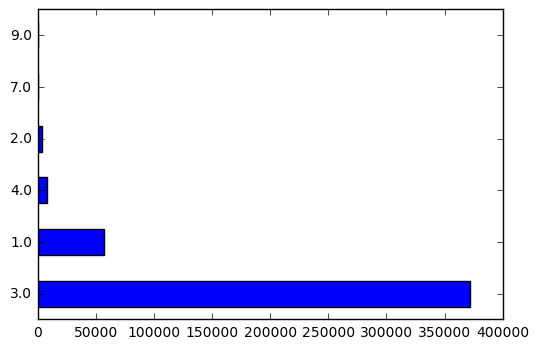

In [16]:
s_diabete = df.DIABETE3.astype('category')
diabete_counts = s_diabete.value_counts()
diabete_counts.plot.barh()
print("Distribution of DIABETE3 in the original dataset")

Distribution of DIABETE3 in the filtered dataset


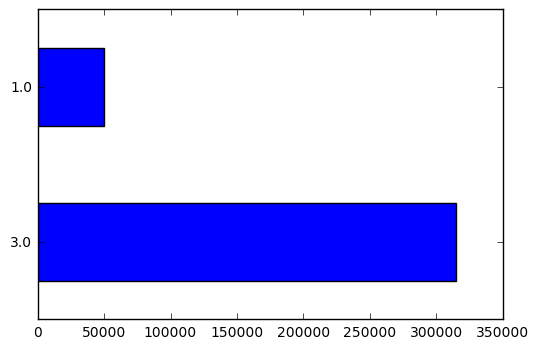

In [17]:
s2_diabete = df_without_columns_allNaN.DIABETE3.astype('category')
s2_diabete.value_counts().plot.barh()
print("Distribution of DIABETE3 in the filtered dataset")

In [18]:
percentages = s2_diabete.value_counts().map(lambda x: x / df.shape[0])
print("Number of interviews per class")
print(percentages)

Number of interviews per class
3.0    0.713210
1.0    0.112623
Name: DIABETE3, dtype: float64


We store the filtered dataset for further analysis:

In [19]:
df_without_columns_allNaN.to_pickle("./initialDataset.pkl")